In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### 交叉验证

In [2]:
# 读取数据
from sklearn.datasets import load_iris
iris = load_iris()
x = iris.data
y = iris.target

In [3]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)
model.fit(x, y)
y_model = model.predict(x)

# 模型的数据准确性
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

In [4]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=0.5)
model.fit(x_train, y_train)
y_fit = model.predict(x_test)
accuracy_score(y_fit, y_test)

0.90666666666666662

In [5]:
from sklearn.cross_validation import cross_val_score
cross_val_score(model ,x, y, cv=5)

array([ 0.96666667,  0.96666667,  0.93333333,  0.93333333,  1.        ])

### 选择最优的模型
*根据训练数据和测试数据的曲线确定最优模型*

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.pipeline import make_pipeline

def polynomialRegression(degree=2, **args):
    return make_pipeline(PolynomialFeatures(degree),
                        LinearRegression(**args))

# 创建数据
def make_data(n, err=1.0, reseed=1):
    rng = np.random.RandomState(reseed)
    x = rng.rand(n, 1) ** 2
    y = 10 - 1.0 / (x.ravel() + 0.1)   # ravel表示将数据降成一维数据
    if err > 0:
        y += rng.randn(n) * err
    return x,y

x,y = make_data(40)

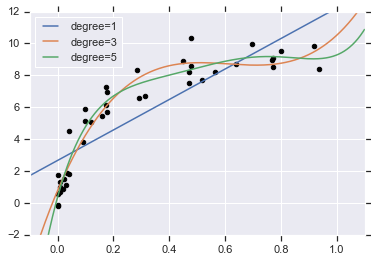

In [15]:
import seaborn as sns
sns.set()

x_test = np.linspace(-0.1,1.1,500)[:, np.newaxis]
plt.scatter(x.ravel(), y, color="black")

for degree in [1,3,5]:
    model = polynomialRegression(degree)
    y_test = model.fit(x, y).predict(x_test)
    plt.plot(x_test.ravel(), y_test, label = 'degree={}'.format(degree))
    plt.xlim(-0.1, 1.1)
    plt.ylim(-2, 12)
    plt.legend(loc="best")

*画出多个degree下的训练和测试的分曲线，并得到最优曲线*

**validation curve 的 参数曲线
如果估计器不是自定义函数，那么参数名称就是估计器参数名称，例如 SCV()，
如果估计器是自定义函数，那么参数名称就是自定义函数中估计器名称 + "__" + 估计器参数 **

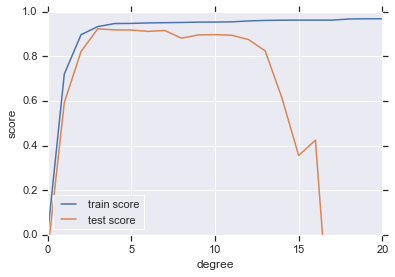

In [17]:
from sklearn.learning_curve import validation_curve
degree_range = np.arange(0,21)
train_score, test_score = validation_curve(polynomialRegression(), x, y, "polynomialfeatures__degree", degree_range, cv=7)
train_score = np.median(train_score,axis=1)
test_score = np.median(test_score,axis=1)
plt.plot(degree_range, train_score, label="train score")
plt.plot(degree_range, test_score, label="test score")
plt.legend(loc="best")
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score')

### 学习曲线
*反映训练集规模的训练得分 / 验证得分曲线*

*学习曲线最重要的特征是，随着训练样本数量的增加，分数会收敛到定值。*

*因此，一旦你的数据多到使模型得分已经收敛，那么增加更多的训练样本也无济于事！*

*改善模型性能的唯一方法就是换模型（通常也是换成更复杂的模型）。*

__学习曲线中，最后训练曲线和验证曲线收敛到一条直线上，__
__该直线的中纵坐标是所有数据作为训练集拟合模型后得到的得分__

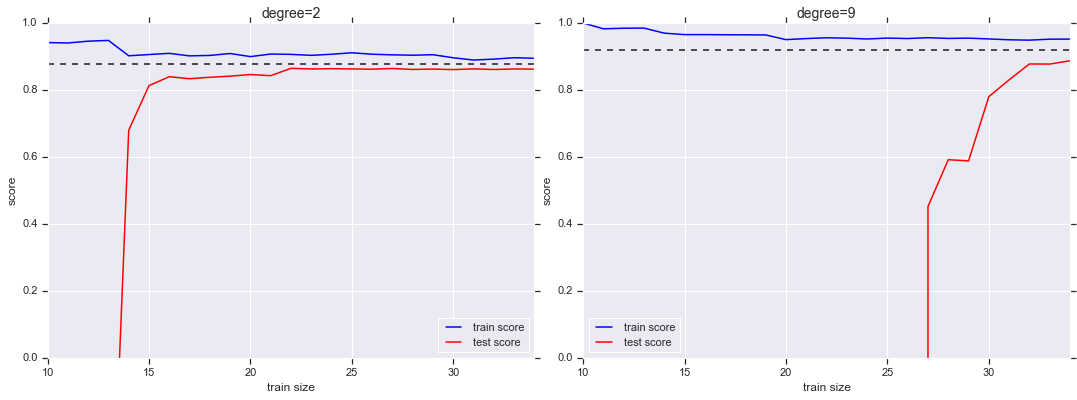

In [18]:
from sklearn.learning_curve import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_score, test_score = learning_curve(polynomialRegression(degree), x, y, cv=7, train_sizes=np.linspace(0.3,1,25)) 
    ax[i].plot(N, np.mean(train_score,1), color='blue', label='train score')
    ax[i].plot(N, np.mean(test_score,1), color='red', label='test score')
    ax[i].hlines(np.mean([train_score[-1], test_score[-1]]), N[0], N[-1], linestyle='dashed')
    
    ax[i].set_ylim(0,1)
    ax[i].set_xlim(N[0],N[-1])
    ax[i].set_xlabel("train size")
    ax[i].set_ylabel("score")
    ax[i].set_title("degree={}".format(degree), size=14)
    ax[i].legend(loc="best")

### 网格化搜索，自动选取适合的参数

In [22]:
from sklearn.grid_search import GridSearchCV
para_dict = {"polynomialfeatures__degree":np.arange(21),
            "linearregression__fit_intercept":(True, False),
            "linearregression__normalize":(True,False)}
grid = GridSearchCV(polynomialRegression(), para_dict, cv=7)
grid.fit(x, y)       # 和普通的评估器一样

GridSearchCV(cv=7, error_score='raise',
       estimator=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'polynomialfeatures__degree': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20]), 'linearregression__fit_intercept': (True, False), 'linearregression__normalize': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

**最优的参数**

In [23]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

**最优的模型**

```plt.axis```： 返回的是轴属性 xmin, xmax, ymin, ymax

(-0.20000000000000001, 1.0000000000000002, -2.0, 12.0)

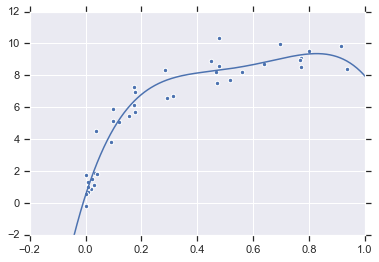

In [25]:
model = grid.best_estimator_
plt.scatter(x.ravel(), y)
lim = plt.axis()
y_test = model.fit(x, y).predict(x_test)
plt.plot(x_test.ravel(), y_test)
plt.axis(lim)

### [pipeline和make_pipeline的区别](https://stackoverflow.com/questions/40708077/what-is-the-difference-between-pipeline-and-make-pipeline-in-scikit#)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
pipe = Pipeline([('vec', CountVectorizer()), ('clf', LogisticRegression())])
param_grid = {'clf__C': [1, 10, 100, 1000]}
gs = GridSearchCV(pipe, param_grid)

            
pipe = make_pipeline(CountVectorizer(), LogisticRegression())     
param_grid = [{'logisticregression__C': [1, 10, 100, 1000]}
gs = GridSearchCV(pipe, param_grid)